In [9]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from utils import *

import tensorflow as tf

In [10]:
def stack_frames(to_be_stacked, compass):
    
    stacked_frames = deque([np.zeros((64,64), dtype=np.uint) for i in range(stack_size)], maxlen=4)
    compass_channel = np.ones(shape=list(to_be_stacked[0].shape[:-1]) + [1], dtype=to_be_stacked.dtype) * compass

    if len(to_be_stacked) != 4:
        for x in range(4-len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[0].reshape(64,64,3), "RGB").convert("L")))
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    else:
        for x in range(len(to_be_stacked)):
            stacked_frames.append(np.array(Image.fromarray(to_be_stacked[x].reshape(64,64,3), "RGB").convert("L")))
        
        stacked_frames = np.stack(stacked_frames, axis=2)
        stacked_frames = np.concatenate([stacked_frames, compass_channel], axis=-1)
    
    return stacked_frames

In [ ]:
path = "C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\"

def generate_random_video(path, batch_size=1):
    frame_shape = 64*64*3
    
    videos = list(os.listdir(path))
    
    random_video_num = np.random.randint(len(videos))
    rand_vid = os.path.join(path+videos[random_video_num])
    
    vid_labels = np.load(rand_vid+"\\rendered.npz", allow_pickle=True)
    vid_labels = [vid_labels[x] for x in vid_labels.keys()]
    
    rewards = np.array(vid_labels[0])
    compass_angle = np.array(vid_labels[1])/180.
    
    camera_x = np.array([x[0] for x in vid_labels[11]])/180.
    camera_y = np.array([x[1] for x in vid_labels[11]])/180.
    place = vid_labels[-1]
    vid_labels = vid_labels[:11]
    vid_labels.append(camera_x)
    vid_labels.append(camera_y)
    vid_labels.append(place)
    vid_labels = vid_labels[3:]
    
    for i in range(len(vid_labels[-1])):
        if vid_labels[-1][i] == "none":
            vid_labels[-1][i] = 0
        else:
            vid_labels[-1][i] = 1
    
    actions = []
    
    for i in range(len(vid_labels[0])):
        action_cluster = []
        for x in range(11):
            action_cluster.append(vid_labels[x][i])
        actions.append(action_cluster)
    
    load_vid = np.load(rand_vid+"\\NDTRAIN.npy", allow_pickle=True)[0]
    
    frames = int(load_vid.shape[0]/frame_shape)
    
    reshaped_vid = load_vid.reshape(frames, 64, 64, 3)[-len(vid_labels[0]):]
    plt.imshow(reshaped_vid[0].astype(np.uint8))
    
    return reshaped_vid, actions, compass_angle, rewards

generate_random_video(path)

In [42]:
def build_model():
    dqn = keras.models.Sequential([
        keras.layers.Conv2D(64, kernel_size=5, strides=2, input_shape=[64, 64, 5]),
        keras.layers.Conv2D(32, kernel_size=3, strides=1),
        keras.layers.Flatten(),
        keras.layers.Dense(50),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(11)
        
    ])

    return dqn

In [43]:
target_model = build_model()
loss_fn = keras.losses.mean_squared_error
optimizer = keras.optimizers.Adam(lr=1e-3)

0
(1, 64, 64, 5)
tf.Tensor(355.40234, shape=(), dtype=float32)
1
(1, 64, 64, 5)
tf.Tensor(22178.088, shape=(), dtype=float32)
2
(1, 64, 64, 5)
tf.Tensor(9480752.0, shape=(), dtype=float32)
3
(1, 64, 64, 5)
tf.Tensor(175013.94, shape=(), dtype=float32)
4
(1, 64, 64, 5)
tf.Tensor(77246.266, shape=(), dtype=float32)
5
(1, 64, 64, 5)
tf.Tensor(345.0016, shape=(), dtype=float32)
6
(1, 64, 64, 5)
tf.Tensor(885787.06, shape=(), dtype=float32)
7
(1, 64, 64, 5)
tf.Tensor(623041.56, shape=(), dtype=float32)
8
(1, 64, 64, 5)
tf.Tensor(1737805.1, shape=(), dtype=float32)
9
(1, 64, 64, 5)
tf.Tensor(325364.25, shape=(), dtype=float32)
10
(1, 64, 64, 5)
tf.Tensor(277536.03, shape=(), dtype=float32)
11
(1, 64, 64, 5)
tf.Tensor(3964.049, shape=(), dtype=float32)
12
(1, 64, 64, 5)
tf.Tensor(72061.31, shape=(), dtype=float32)
13
(1, 64, 64, 5)
tf.Tensor(25504.736, shape=(), dtype=float32)
14
(1, 64, 64, 5)
tf.Tensor(218921.19, shape=(), dtype=float32)
15
(1, 64, 64, 5)
tf.Tensor(49166.89, shape=(), dtype

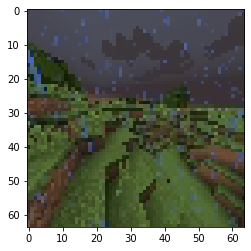

In [44]:
q_model = keras.models.clone_model(target_model)
q_model.set_weights(target_model.get_weights())

def train_model(target_model, q_model, n_epochs=100):
    tau = 10
    discount_factor = 0.95
    
    for epoch in range(n_epochs):
        video, actions, compass_angle, rewards = generate_random_video(path)

        print(epoch)
        batch = np.random.randint(video.shape[0])
        
        state = np.array(video[batch-4:batch])
        n_state = np.array(video[batch-3:batch+1])
        actions = np.array(actions[batch])
        rewards = np.array(rewards[batch])
        
        frames = stack_frames(state, compass_angle[batch]).reshape(1, 64, 64, 5)
        n_frames = stack_frames(n_state, compass_angle[batch+1]).reshape(1, 64, 64, 5)
        print(frames.shape)
        
        for a in range(len(actions)):
            if actions[a] != 0:
                if actions[a] != 1:
                    actions[a] = 1
        
        target_values = target_model.predict(n_frames)
        max_target_values = np.max(target_values, axis=1)
        target_Q_values = (rewards +
                          discount_factor * max_target_values)
        mask = tf.one_hot(actions, 11)
        with tf.GradientTape() as tape:
            all_Q_values = q_model(frames)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        
        print(loss)
        
        grads = tape.gradient(loss, q_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, q_model.trainable_variables))
        
        if epoch % tau == 0:
            target_model.set_weights(q_model.get_weights())

train_model(target_model, q_model)

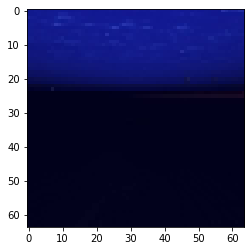

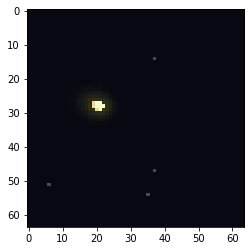

Guessed rewards:  [[   5.  424.   95. -161.  -20.  -92.  -51.   10.   56.  -42.  -35.]]
Target rewards:  [[   4.  473.  124. -197.   59.  -28.  -56.  -34.   12.    7.   -8.]]
Actions:  ['1' '1' '0' '0' '1' '0' '0' '0' '0.0' '0.0' '0']


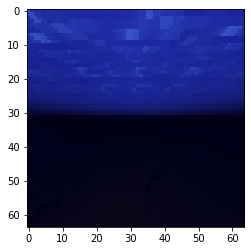

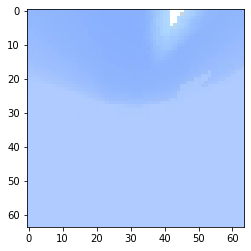

Guessed rewards:  [[  48.  245.  103. -114.   16.   -5.  -36.  -27.    4.  -22.  -32.]]
Target rewards:  [[ 69. 140.  81. -91.  45.  34. -22. -38. -11. -18. -26.]]
Actions:  ['1' '0' '0' '0' '1' '0' '1' '0' '0.0' '0.0' '0']


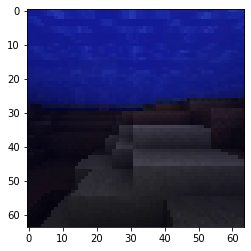

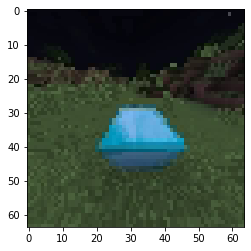

Guessed rewards:  [[   7.  347.  106. -157.   61.   -3.  -34.  -36.    2.   12.  -10.]]
Target rewards:  [[  14.  707.  166. -289.   61.  -65.  -88.  -52.   47.   -4.   -3.]]
Actions:  ['1' '0' '0' '0' '0' '0' '1' '0' '0.025833342' '-0.058333334' '0']


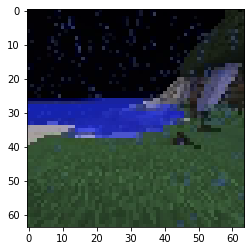

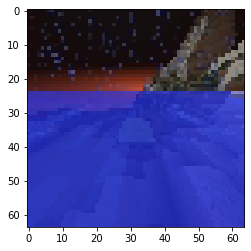

Guessed rewards:  [[  16.  387.   87. -147.   12.  -53.  -43.   -9.   12.   -2.   -1.]]
Target rewards:  [[  23. 1067.  289. -471.  161.  -39. -114. -113.   50.   18.  -21.]]
Actions:  ['1' '0' '0' '0' '1' '0' '0' '0' '0.0' '0.0' '0']


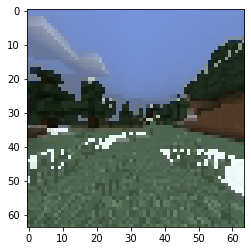

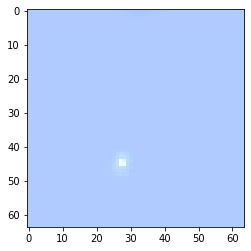

Guessed rewards:  [[  25.  501.  157. -229.   84.   16.  -51.  -42.   21.   -2.  -14.]]
Target rewards:  [[  48.  525.  154. -234.   51.   -4.  -94.  -38.   27.   26.  -28.]]
Actions:  ['1' '0' '0' '0' '0' '0' '1' '0' '0.0' '0.0' '0']


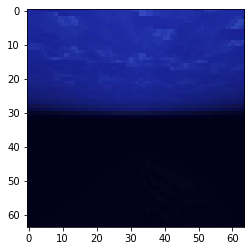

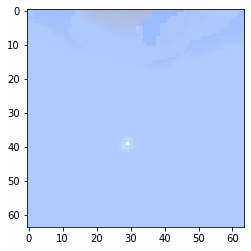

IndexError: index 0 is out of bounds for axis 0 with size 0

In [56]:
for i in range(10):    
    video, actions, compass_angle, rewards = generate_random_video(path)

    batch = np.random.randint(video.shape[0])
    frames = np.array(video[batch-4:batch])
    next_frames = np.array(video[batch-3:batch+1])

    plt.imshow(video[0].astype(np.uint8))
    plt.show()

    plt.imshow(video[-1].astype(np.uint8))
    plt.show()

    actions = np.array(actions[batch])
    frames = stack_frames(video, compass_angle[batch]).reshape(1, 64, 64, 5)
    n_frames = stack_frames(next_frames, compass_angle[batch+1]).reshape(1, 64, 64, 5)

    print("Guessed rewards: ", np.round(q_model(frames)))
    print("Target rewards: ", np.round(target_model(n_frames)))
    print("Actions: ", actions)

In [16]:
target_model.save("target_q_model.h5")
q_model.save("q_model.h5")